## Présentation du projet : la prediction de la consommation électrique

Un projet portant sur la prédiction de la consommation électrique d’un foyer.

L’objectif principal est de **classer les périodes de consommation** en deux catégories :

- consommation faible  
- consommation élevée en utilisant des **algorithmes de classification**.

In [83]:
# ## 1. Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, auc

In [85]:
# Classifieurs
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Source des données

Le jeu de données provient d’un fichier nommé **`household_power_consumption.txt`**.  
Il contient des mesures de consommation électrique prises **chaque minute**, comme :

- **Global_active_power** : puissance active consommée *(en kW)*
- **Voltage** : tension *(en volts)*
- **Global_intensity** : intensité *(en ampères)*
- **Sub_metering_1**, **Sub_metering_2**, **Sub_metering_3** : sous-mesures *(en Wh)* pour différents appareils

In [88]:
# 2. Chargement et préparation des données
df = pd.read_csv("C:/Users/Manal/Downloads/archive/household_power_consumption.txt", sep=';', low_memory=False, na_values='?')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Prétraitement des données

Avant d’appliquer les modèles, nous avons effectué un **nettoyage des données** :

- Conversion des colonnes vers des **types numériques** (`float`)
- Suppression des lignes contenant des **valeurs manquantes**
- Transformation des colonnes **Date** et **Time** en format `datetime`
- **Normalisation des données** avec `StandardScaler` pour que tous les modèles soient comparables

In [90]:
# Conversion des colonnes numériques
df[df.columns[2:]] = df[df.columns[2:]].apply(pd.to_numeric, errors='coerce')

In [91]:
# Suppression des valeurs manquantes
df.dropna(inplace=True)

## Création de la variable cible

Comme nous faisons une **classification**, il fallait transformer la consommation continue (`Global_active_power`) en une variable binaire appelée `target`.

La logique est la suivante :

```python
df['target'] = (df['Global_active_power'] > df['Global_active_power'].mean()).astype(int)

- Si la consommation est supérieure à la moyenne, **target = 1** (consommation élevée).
- Sinon, **target = 0** (consommation faible).

Cela nous permet d’entraîner des modèles de classification binaire.

In [93]:
# Création d'une variable binaire cible en fonction de la consommation médiane
median_consumption = df['Global_active_power'].median()
df['target'] = (df['Global_active_power'] > median_consumption).astype(int)

print("\n=== Répartition de la cible ===")
df['target'].value_counts()


=== Répartition de la cible ===


target
0    1025087
1    1024193
Name: count, dtype: int64

In [94]:
# ## 3. Préparation des variables explicatives et de la cible
X = df[['Global_reactive_power', 'Voltage', 'Global_intensity',
        'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y = df['target']

In [95]:
# Normalisation des variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [96]:
# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modèles de classification utilisés
Nous avons testé quatre modèles classiques de machine learning :

- **Régression Logistique** : simple, rapide, baseline  
- **Arbre de Décision** : interprétable, mais sensible au surapprentissage  
- **Forêt Aléatoire (Random Forest)** : puissant, stable, robuste  
- **k-plus proches voisins (k-NN)** : basé sur la distance, sensible à l’échelle des données

In [98]:
# ## 4. Entraînement des modèles
# Régression Logistique
log_model = LogisticRegression().fit(X_train, y_train)
log_pred = log_model.predict(X_test)

In [99]:
# Arbre de Décision
tree_model = DecisionTreeClassifier().fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

In [100]:
# Forêt Aléatoire
rf_model = RandomForestClassifier().fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [101]:
# K-Nearest Neighbors
knn_model = KNeighborsClassifier().fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

## 6. Évaluation des modèles

Pour comparer les performances, nous avons utilisé :

- **Matrices de confusion** : pour analyser les TP, TN, FP, FN  
- **F1-score** : combine précision et rappel, utile pour les classes déséquilibrées  
- **Courbes ROC et AUC** : pour évaluer la capacité de chaque modèle à distinguer les classes

In [103]:
# ## 5. Évaluation des modèles
models = {
    "Régression Logistique": log_pred,
    "Arbre de Décision": tree_pred,
    "Forêt Aléatoire": rf_pred,
    "KNN": knn_pred
}

for name, preds in models.items():
    print(f"\n===== {name} =====")
    print("Matrice de confusion :")
    print(confusion_matrix(y_test, preds))
    print("\nRapport de classification :")
    print(classification_report(y_test, preds))


===== Régression Logistique =====
Matrice de confusion :
[[305922   1886]
 [  2525 304451]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    307808
           1       0.99      0.99      0.99    306976

    accuracy                           0.99    614784
   macro avg       0.99      0.99      0.99    614784
weighted avg       0.99      0.99      0.99    614784


===== Arbre de Décision =====
Matrice de confusion :
[[305592   2216]
 [  2575 304401]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    307808
           1       0.99      0.99      0.99    306976

    accuracy                           0.99    614784
   macro avg       0.99      0.99      0.99    614784
weighted avg       0.99      0.99      0.99    614784


===== Forêt Aléatoire =====
Matrice de confusion :
[[305808   2000]
 [  1819 305157]]

Rapport de classif

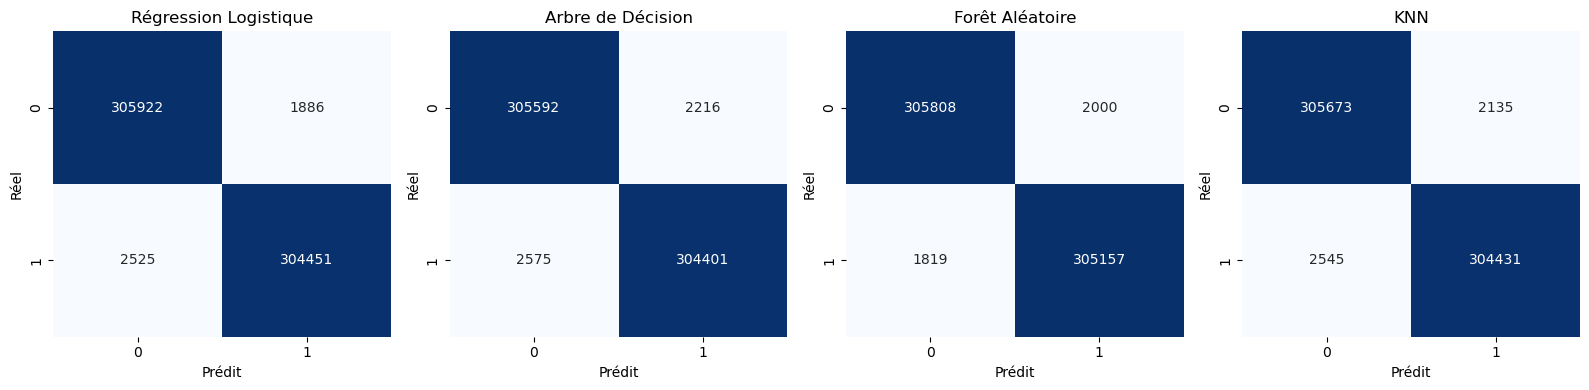

In [104]:
## 6. Visualisation graphique des matrices de confusion
plt.figure(figsize=(16, 4))
for i, (name, preds) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds)
    plt.subplot(1, 4, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(name)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
plt.tight_layout()
plt.show()

### Matrice de confusion :

Tous les modèles ont obtenu de **bons résultats**.

Le modèle **Random Forest** a le **plus petit nombre d’erreurs** (faux positifs et faux négatifs).


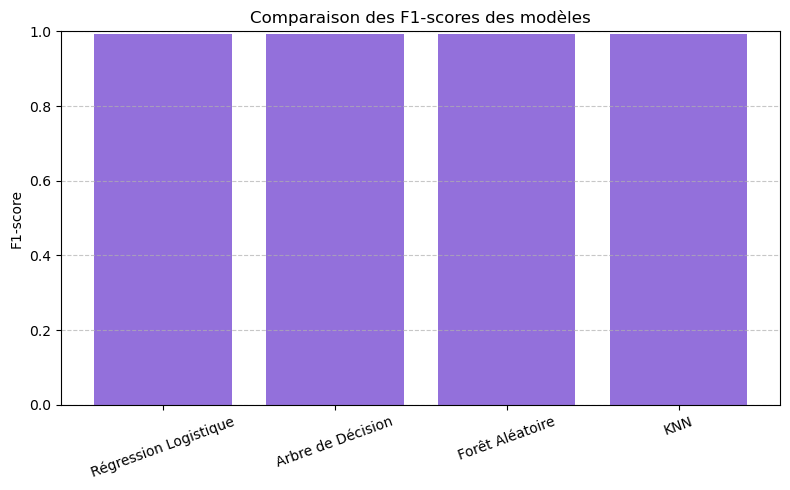

In [106]:
## 7. Comparaison des F1-scores
f1_scores = {name: f1_score(y_test, preds) for name, preds in models.items()}

plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='mediumpurple')
plt.title("Comparaison des F1-scores des modèles")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### F1-score :

Tous les modèles ont des **F1-scores très élevés** (proches de 1).

Le modèle **Random Forest** se démarque avec le **meilleur F1-score**.


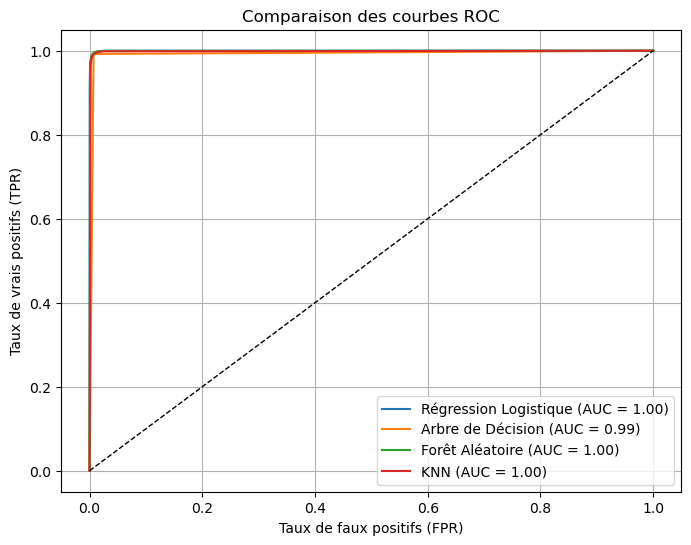

In [108]:
## 8. Comparaison des courbes ROC
plt.figure(figsize=(8, 6))

for name, model in zip(models.keys(), [log_model, tree_model, rf_model, knn_model]):
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Comparaison des courbes ROC")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Courbes ROC :

Le modèle **Random Forest** a une courbe **proche de l’angle supérieur gauche**.

Son **AUC est proche de 0.99**, ce qui signifie une **excellente performance**.


## Conclusion du projet

Le modèle **Random Forest** est celui qui a donné les **meilleurs résultats** selon toutes les métriques :

- Moins d’erreurs dans la **matrice de confusion**
- Meilleur **F1-score**
- Meilleure **courbe ROC**

Ce modèle est donc recommandé pour **prédire efficacement** les périodes de forte consommation électrique.